#Задача “Оценка качества огранки бриллиантов”.

Есть данные по характеристикам бриллиантов в файле diamonds.csv.

Целевая переменная,характеризующая качество огранки бриллиантов cut. Разбейте имеющийся датасет на обучающую и тестовую выборки. Считая, что значение cut в тестовойвыборке неизвестно, предскажите его с использованием деревьев классификации (используйте from sklearn.tree import DecisionTreeClassifier),случайного леса (используйте from sklearn.ensembleimportRandomForestClassifier), бустинговых методов (используйте fromxgboostimport XGBClassifier, а затем from catboost import CatBoostClassifier), метода ближайших соседей (from sklearn.neighbors import KNeighborsClassifier)и метода опорных векторов (используйте from sklearn.svmimport LinearSVC).

Сравните полученные результаты с фактическими данными, сравнитерезультаты работы разных методов между собой и произведите оценку качества классификации. В качестве отчета загрузите colab (jupyter) - ноутбук.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier

In [37]:
!pip3 install catboost
!pip install --upgrade xgboost

In [38]:
df = pd.read_csv('/content/sample_data/diamonds.csv')
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [39]:
df = df.drop(df.columns[0], axis=1)  # Удаление первого столбца
df = pd.get_dummies(data=df, columns=['color', 'clarity'])  # One Hot Encoding для текстовых столбцов

In [40]:
df

,carat,cut,depth,table,price,x,y,z,color_D,color_E,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,False,True,...,False,False,False,False,False,False,True,False,False,False
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,False,False,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,60.8,57.0,2757,5.75,5.76,3.50,True,False,...,False,False,False,False,True,False,False,False,False,False
53936,0.72,Good,63.1,55.0,2757,5.69,5.75,3.61,True,False,...,False,False,False,False,True,False,False,False,False,False
53937,0.70,Very Good,62.8,60.0,2757,5.66,5.68,3.56,True,False,...,False,False,False,False,True,False,False,False,False,False
53938,0.86,Premium,61.0,58.0,2757,6.15,6.12,3.74,False,False,...,False,False,False,False,False,True,False,False,False,False


In [41]:
# Преобразование целевой переменной
y = df['cut']
X = df.drop('cut', axis=1)
y = y.replace({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4})

<ipython-input-41-e98049f58314>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4})


In [42]:
y.value_counts()

,count
cut,
4,21551
3,13791
2,12082
1,4906
0,1610


In [43]:
y = y.replace({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4})
y.value_counts()

,count
cut,
4,21551
3,13791
2,12082
1,4906
0,1610


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)

In [45]:
def print_predict_comparison(y_pred, y_test, target_numbers_vals):
    for i in range(len(y_pred)):
        print(f'{i+1:<4} |  факт={y_test.values[i]:<10} |  предсказ={y_pred[i]:<10} |  дельта={y_test.values[i] - y_pred[i]}')


#Деревья классификации

In [47]:
dtc = DecisionTreeClassifier(max_depth = 9)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9)

In [21]:
y_pred1 = dtc.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       465
           1       0.82      0.64      0.72      1403
           2       0.69      0.34      0.46      3626
           3       0.65      0.85      0.73      4149
           4       0.82      0.92      0.86      6539

    accuracy                           0.75     16182
   macro avg       0.77      0.73      0.73     16182
weighted avg       0.75      0.75      0.73     16182



#Случайный лес

In [22]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
y_pred2 = rfc.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       465
           1       0.76      0.68      0.72      1403
           2       0.66      0.48      0.55      3626
           3       0.73      0.81      0.77      4149
           4       0.82      0.92      0.87      6539

    accuracy                           0.77     16182
   macro avg       0.78      0.75      0.76     16182
weighted avg       0.76      0.77      0.76     16182



#Бустинговые методы

In [51]:
!pip install --upgrade xgboost

In [54]:
xgbc = XGBClassifier(learning_rate=0.07, max_depth=5)
xgbc.fit(X_train, y_train)
y_pred3 = xgbc.predict(X_test)
print("Бустинговый метод XGBoost:")
print(classification_report(y_test, y_pred3))

Бустинговый метод XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       465
           1       0.83      0.63      0.72      1403
           2       0.71      0.36      0.48      3626
           3       0.66      0.86      0.74      4149
           4       0.82      0.92      0.87      6539

    accuracy                           0.75     16182
   macro avg       0.78      0.73      0.74     16182
weighted avg       0.75      0.75      0.74     16182



In [55]:
cbc = CatBoostClassifier(iterations=550, learning_rate=0.05, depth=5, verbose=0)
cbc.fit(X_train, y_train)
y_pred4 = cbc.predict(X_test)
print("Бустинговый метод CatBoost:")
print(classification_report(y_test, y_pred4))

Бустинговый метод CatBoost:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       465
           1       0.81      0.65      0.72      1403
           2       0.71      0.42      0.52      3626
           3       0.69      0.84      0.76      4149
           4       0.82      0.92      0.87      6539

    accuracy                           0.77     16182
   macro avg       0.78      0.75      0.75     16182
weighted avg       0.76      0.77      0.75     16182



#Метод ближайших соседей

In [28]:
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [29]:
y_pred5 = knc.predict(X_test)
print(classification_report(y_test, y_pred5))

# Точность метода ближайших соседей значительно ниже, чем у остальных методов

              precision    recall  f1-score   support

           0       0.41      0.28      0.34       465
           1       0.28      0.34      0.31      1403
           2       0.33      0.32      0.32      3626
           3       0.54      0.50      0.52      4149
           4       0.70      0.73      0.72      6539

    accuracy                           0.53     16182
   macro avg       0.45      0.44      0.44     16182
weighted avg       0.53      0.53      0.53     16182



#Метод опорных векторов

In [58]:
svc = LinearSVC(C=100, random_state=42)
svc.fit(X_train, y_train)
y_pred6 = svc.predict(X_test)
print("Метод опорных векторов:")
print(classification_report(y_test, y_pred6))

Метод опорных векторов:
              precision    recall  f1-score   support

           0       0.55      0.06      0.10       465
           1       0.00      0.00      0.00      1403
           2       1.00      0.00      0.00      3626
           3       0.53      0.67      0.59      4149
           4       0.57      0.94      0.71      6539

    accuracy                           0.55     16182
   macro avg       0.53      0.33      0.28     16182
weighted avg       0.60      0.55      0.44     16182



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
methods = [
    "Деревья классификации",
    "Случайный лес",
    "Бустинговые методы: XGBoost",
    "Бустинговые методы: CatBoost",
    "Метод ближайших соседей",
    "Метод опорных векторов"
]
results = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]
models = [dtc, rfc, xgbc, cbc, knc, svc]


In [60]:
print("\nОценка качества классификации:")
for i in range(len(methods)):
    print(methods[i])
    print(classification_report(y_test, results[i], zero_division=0))
    print("score =", models[i].score(X_test, y_test), "\n")


Оценка качества классификации:
Деревья классификации
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       465
           1       0.82      0.64      0.72      1403
           2       0.70      0.34      0.46      3626
           3       0.65      0.85      0.73      4149
           4       0.82      0.92      0.86      6539

    accuracy                           0.75     16182
   macro avg       0.77      0.73      0.73     16182
weighted avg       0.75      0.75      0.73     16182

score = 0.7472500308985293 

Случайный лес
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       465
           1       0.76      0.67      0.71      1403
           2       0.66      0.47      0.55      3626
           3       0.73      0.81      0.77      4149
           4       0.82      0.92      0.87      6539

    accuracy                           0.77     16182
   macro avg       0.78      0.75 

ROC-кривые:


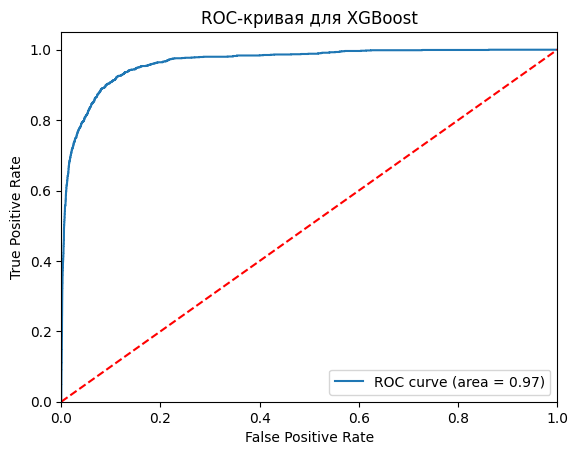

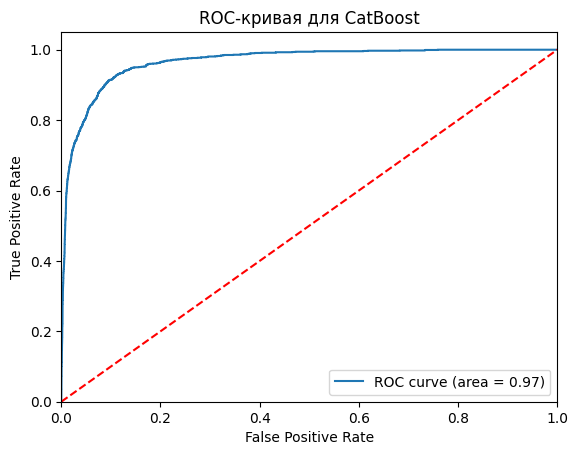

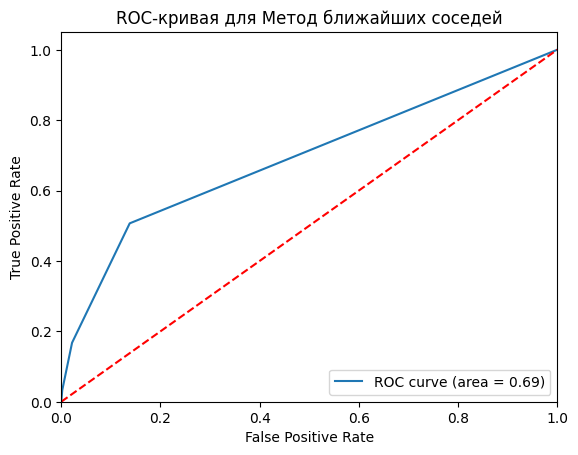

In [61]:
# Построение ROC-кривых
def buildROC(x_test, y_test, model, method_name):
    if hasattr(model, "predict_proba"):  # Проверка на наличие predict_proba
        y_pred_proba = model.predict_proba(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)  # One-vs-Rest подход
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC-кривая для {method_name}')
        plt.legend(loc="lower right")
        plt.show()

print("ROC-кривые:")
buildROC(X_test, y_test, xgbc, "XGBoost")
buildROC(X_test, y_test, cbc, "CatBoost")
buildROC(X_test, y_test, knc, "Метод ближайших соседей")

Наилучшими моделями являются XGBoost и CatBoost, которые показывают практически идентичные результаты с AUC ~0.97. Они лучше всего справляются с задачей многоклассовой классификации.

Метод ближайших соседей значительно уступает по качеству, его AUC ~0.69. Это подтверждает, что данный метод менее эффективен в случае сложных задач, требующих выявления сложных паттернов в данных.